In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# import spacy
import re
import string
import numpy as np

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

/home/stve/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 1. EDA

In [ ]:
data = pd.read_csv('imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [ ]:
# data/label distribution
Counter(data.sentiment)

Counter({'positive': 25000, 'negative': 25000})

(array([3.4883e+04, 1.0845e+04, 2.9210e+03, 1.0330e+03, 2.9300e+02,
        1.4000e+01, 4.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([   32. ,  1399.2,  2766.4,  4133.6,  5500.8,  6868. ,  8235.2,
         9602.4, 10969.6, 12336.8, 13704. ]),
 <a list of 10 Patch objects>)

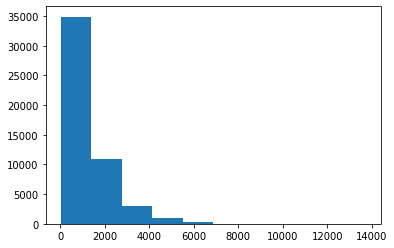

In [ ]:
# review lengths
plt.hist(list(map(len, data.review)))

# 2. Data Preprocessing
- remove stop words, punctuation, capital letters
- Tokenize
- Stemming
- Lemmatizing

In [ ]:
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer

In [ ]:
en_stop = get_stop_words('en')

In [ ]:
p_stemmer = PorterStemmer()
def preprocess(rws):
    # Special normalization
    ## getting rid of < br >
    res = re.sub(r'<.*?>', '', rws)
    # Lower case
    res = res.lower()
    # Tokenize
    res = word_tokenize(res)
    # Remove non-alphabetical (ignoring numbers, cause sometimes they could be misleading)
    res = [w for w in res if w.isalpha()]
    # Stop words
    res = [w for w in res if w not in en_stop]
    # Stemming if doing word-wise
    res = [p_stemmer.stem(w) for w in res]
    # Didn't do Lemmatize here, since Stemming is good enough
    return ' '.join(res)

In [ ]:
rws = data.review.values

In [ ]:
# preprocessing
rws_processed = []
n = len(rws)
for i in range(n):
    rws_processed.append(preprocess(rws[i]))
    print('Pre-processing {:.2f}%'.format((i+1)/n*100), end='\r')

In [ ]:
rws_processed = np.array(rws_processed)

In [ ]:
lbs = data.sentiment == 'positive'

# 3. Vectorization

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# applying TF-IDF
# 1. limit vocab = 2000, from most frequent
# 2. removing stop_words
# 3. removing numbers
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(rws)
# print(vectorizer.get_feature_names())
print(X.shape)

(50000, 2000)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, lbs, random_state=0)

### LR on TF-IDF

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Validation Acc: % .2f' % (np.mean(y_pred == y_test)*100))

Validation Acc:  87.82


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.87      0.88      6291
        True       0.87      0.89      0.88      6209

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



### SVM on TF-IDF

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()

In [ ]:
X_pca = pca.fit_transform(X.toarray())

In [ ]:
pca.explained_variance_ratio_.cumsum()[1000]
# I don't think PCA works great here, since we only get 78% variation explained
# even if we include 1000 principle components.

0.7790538708611334

In [ ]:
# SVC blows the memory up for huge number of training examples (quadratically)
# svm = SVC()
# svm.fit(X_train, y_train)
# y_pred = lr.predict(X_test)

In [ ]:
# Linear SVM
svm_l = LinearSVC()
svm_l.fit(X_train, y_train)
y_pred = svm_l.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.88      0.87      0.88      6291
        True       0.87      0.88      0.88      6209

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



### NNs on TF-IDF vectors

In [ ]:
import keras
from keras import Sequential, layers

In [ ]:
model = Sequential()
model.add(layers.Dense(200, input_dim=2000, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

Train on 37500 samples, validate on 12500 samples
Epoch 1/30
37500/37500 [==============================] - 2s 53us/step - loss: 0.6910 - accuracy: 0.5769 - val_loss: 0.6893 - val_accuracy: 0.6216
Epoch 2/30
37500/37500 [==============================] - 2s 49us/step - loss: 0.6866 - accuracy: 0.6595 - val_loss: 0.6840 - val_accuracy: 0.6814
Epoch 3/30
37500/37500 [==============================] - 2s 50us/step - loss: 0.6800 - accuracy: 0.7074 - val_loss: 0.6765 - val_accuracy: 0.7106
Epoch 4/30
37500/37500 [==============================] - 2s 50us/step - loss: 0.6706 - accuracy: 0.7345 - val_loss: 0.6655 - val_accuracy: 0.7293
Epoch 5/30
37500/37500 [==============================] - 2s 50us/step - loss: 0.6563 - accuracy: 0.7518 - val_loss: 0.6482 - val_accuracy: 0.7498
Epoch 6/30
37500/37500 [==============================] - 3s 74us/step - loss: 0.6341 - accuracy: 0.7676 - val_loss: 0.6218 - val_accuracy: 0.7618
Epoch 7/30
37500/37500 [==============================] - 3s 72us/st

In [ ]:
y_pred = model.predict(X_test) > 0.5

In [ ]:
# the results is similar to LR and LinearSVC
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.89      0.88      6291
        True       0.89      0.87      0.88      6209

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500

